# Leer datasets

In [30]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

heart_disease = heart_disease.data.features 
#drop null values
heart_disease = heart_disease.dropna()
print(heart_disease.shape)
heart_disease.head()

(297, 13)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


# Realizamos los clusters

In [31]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS, BisectingKMeans
from sklearn.mixture import GaussianMixture
n_clusters = 3
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.7, min_samples=5),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
    'MeanShift': MeanShift(),
    'SpectralClustering': SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors'),
    'AffinityPropagation': AffinityPropagation(),
    'Birch': Birch(n_clusters=n_clusters),
    'OPTICS': OPTICS(min_samples=5, cluster_method='xi', xi=0.05),
    'BisectingKMeans': BisectingKMeans(n_clusters=n_clusters, random_state=42),
    'GaussianMixture': GaussianMixture(n_components=n_clusters, random_state=42)
}
results = {}
for name, algorithm in clustering_algorithms.items():
    try:
        algorithm.fit(heart_disease)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        elif hasattr(algorithm, 'predict'):
            labels = algorithm.predict(heart_disease)
        else:
            labels = algorithm.means_.argmax(axis=0)  # For GaussianMixture
        results[name] = labels
    except Exception as e:
        print(f"Error with {name}: {e}")

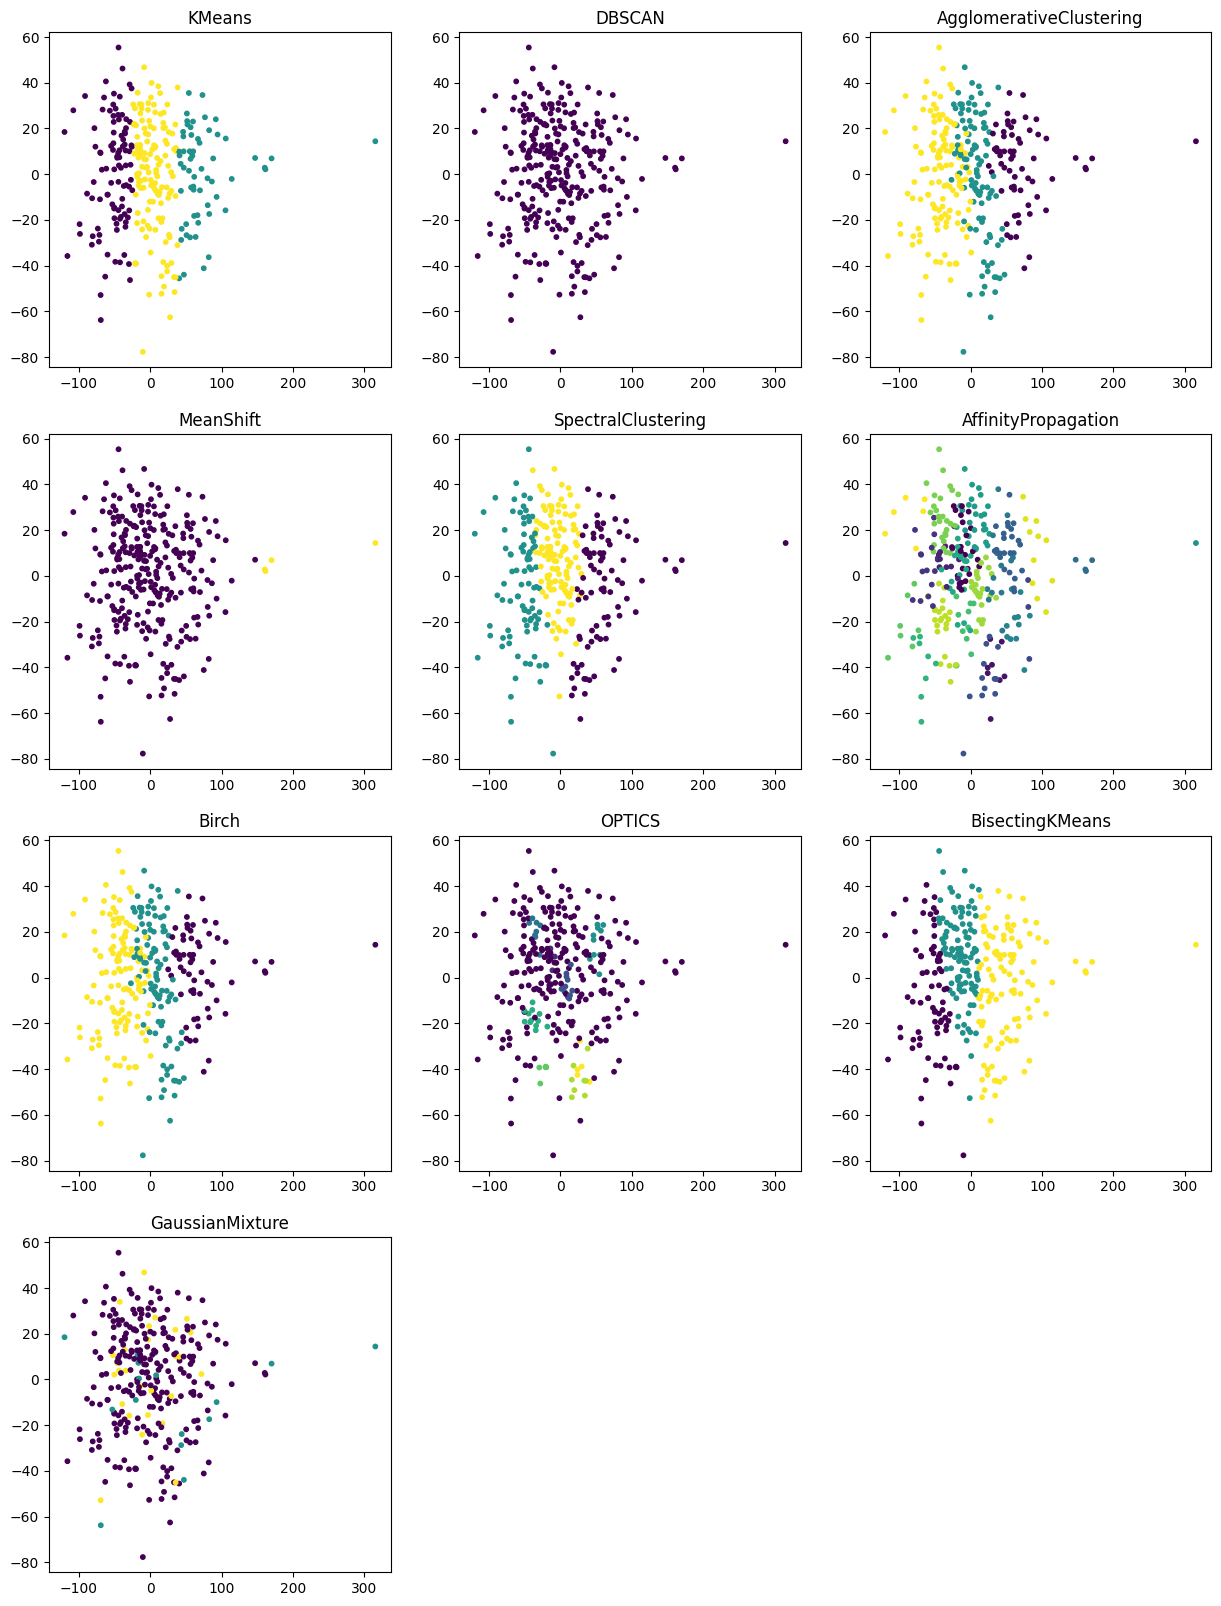

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
heart_disease_pca = pca.fit_transform(heart_disease)
plt.figure(figsize=(15, 20))
for i, (name, labels) in enumerate(results.items(), 1):
    plt.subplot(4, 3, i)
    plt.scatter(heart_disease_pca[:, 0], heart_disease_pca[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(name)

In [33]:
#definimos dunn index
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
            inter_cluster_distances.append(inter_distance)

        intra_distance = np.mean([np.linalg.norm(data[labels == unique_label] - data[labels == unique_label].mean(axis=0)) for unique_label in unique_labels])
        intra_cluster_distances.append(intra_distance)

    dunn_index_value = min(inter_cluster_distances) / max(intra_cluster_distances)
    return dunn_index_value

In [34]:
#podrias generar una metrica en que se calcule el valor maximo de distancia (entre las menores distancias de cada punto con otro dentro del mismo cluster) dividido por el valor minimo de distancia entre cualquier punto de un cluster con otro punto de otro cluster
import numpy as np
from sklearn.metrics import pairwise_distances

def custom_metric(X, labels):
    X = np.array(X)
    distances = pairwise_distances(X)
    n = len(X)
    
    # Numerador: máximo de las mínimas distancias dentro del mismo cluster
    max_min_intra = -np.inf
    for i in range(n):
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # Exclude itself
        if np.any(same_cluster):
            min_dist = np.min(distances[i][same_cluster])
            max_min_intra = max(max_min_intra, min_dist)
    
    # Denominador: mínima distancia entre puntos de distintos clusters
    min_inter = np.inf
    for i in range(n):
        other_cluster = (labels != labels[i])
        if np.any(other_cluster):
            min_dist = np.min(distances[i][other_cluster])
            min_inter = min(min_inter, min_dist)

    M = max_min_intra / min_inter if min_inter != 0 else np.inf
    return 1 /( 1 + M)


In [35]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from permetrics import ClusteringMetric
def evaluate_clustering(data, labels):
    if len(set(labels)) < 2:
        return {
            'Silhouette Score': None,
            'Calinski-Harabasz Score': None,
            'Davies-Bouldin Score': None,
            'Dunn Index': None,
            'custom_metric': None,
            'dbcv': None
        }
    
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    dunn = dunn_index(data.values, labels)
    custom = custom_metric(data.values, labels)
    dbcv = ClusteringMetric(X=data.values, y_pred=labels).DBCVI()

    return {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin,
        'Dunn Index': dunn,
        'custom_metric': custom,
        'dbcv': dbcv
    }
evaluation_results = {}
for name, labels in results.items():
    evaluation_results[name] = evaluate_clustering(heart_disease, labels)
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df = evaluation_df.rename(columns={
    'Silhouette Score': 'Silhouette',
    'Calinski-Harabasz Score': 'Calinski-Harabasz',
    'Davies-Bouldin Score': 'Davies-Bouldin',
    'Dunn Index': 'Dunn',
    'custom_metric': 'Custom Metric'
})
evaluation_df

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv
KMeans,0.284388,191.142241,1.144593,0.141845,0.039672,0.950878
DBSCAN,None,None,None,None,None,None
AgglomerativeClustering,0.239426,168.984478,1.294715,0.125746,0.075382,0.954531
MeanShift,0.635291,53.692691,0.530414,0.379429,0.105819,0.668207
SpectralClustering,0.266526,181.821861,1.190007,0.128674,0.05345,0.94685
AffinityPropagation,0.238056,111.134902,1.031036,0.391495,0.098481,0.990938
Birch,0.239426,168.984478,1.294715,0.125746,0.075382,0.954531
OPTICS,-0.323856,4.406433,2.340957,0.099177,0.039672,NaN
BisectingKMeans,0.241938,168.228942,1.25825,0.117271,0.046868,0.946772
GaussianMixture,-0.077274,2.919115,9.518457,0.014427,0.035406,0.995819


In [36]:
#elige los mejores 3 resultados ponderando el orden de cada métrica
def weighted_score(row):
    weights = {
        'Silhouette': 0.2,
        'Calinski-Harabasz': -0.2,
        'Davies-Bouldin': 0.2,  # Negativo porque queremos minimizar
        'Dunn': 0.2,
        'Custom Metric': 0.5 # Puedes ajustar este peso según su importancia
    }
    score = (row['Silhouette'] * weights['Silhouette'] +
                1/(1+row['Calinski-Harabasz']) * weights['Calinski-Harabasz'] +
                1/(1+row['Davies-Bouldin']) * weights['Davies-Bouldin'] +
                row['Dunn'] * weights['Dunn'] +
                row['Custom Metric'] * weights['Custom Metric'])
    return score
# Replace None values with 0 for scoring
evaluation_df_filled = evaluation_df.fillna(0)
evaluation_df_filled['Weighted Score'] = evaluation_df_filled.apply(weighted_score, axis=1)
top_3_algorithms = evaluation_df_filled.nlargest(3, 'Weighted Score')
top_3_algorithms

/tmp/ipykernel_212164/2114172724.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  evaluation_df_filled = evaluation_df.fillna(0)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv,Weighted Score
MeanShift,0.635291,53.692691,0.530414,0.379429,0.105819,0.668207,0.382880
AffinityPropagation,0.238056,111.134902,1.031036,0.391495,0.098481,0.990938,0.271839
KMeans,0.284388,191.142241,1.144593,0.141845,0.039672,0.950878,0.197299


# Interpretar

In [37]:
import sys
sys.path.append('../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

In [38]:
# interpretamos solo los mejores 3 resultados y guardamos los modelos
saved_models = {}
top_3_labels = {name: results[name] for name in top_3_algorithms.index}
top_3_data = heart_disease.copy()
for name, labels in top_3_labels.items():
    n = len(np.unique(labels))
    X_train, X_test, y_train, y_test = train_test_split(top_3_data, labels, test_size=0.2, random_state=42)
    print(f'Processing {name} with {n} clusters')
    
    # Ripper
    ripper = MultiClassRipperClassifier(random_state=43)
    ripper.fit(X_train, y_train)
    y_pred_ripper = ripper.predict(X_test)
    print(f'Ripper Accuracy for {name}: {accuracy_score(y_test, y_pred_ripper):.2f}')
    saved_models.setdefault(name, {})['ripper'] = ripper
    
    # Decision Tree
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    print(f'Decision Tree Accuracy for {name}: {accuracy_score(y_test, dtree_pred):.2f}')
    saved_models[name]['dtree'] = dtree
    
    # DSGD
    ds = DSClassifierMultiQ(n, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
    X = X_train.to_numpy()
    losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    x_test = X_test.to_numpy()
    y_pred_ds = ds.predict(x_test)
    print(f'DSGD Accuracy for {name}: {accuracy_score(y_test, y_pred_ds):.2f}')
    saved_models[name]['ds'] = ds
    
    print('--' * 40)


Processing MeanShift with 2 clusters
Ripper Accuracy for MeanShift: 1.00
Decision Tree Accuracy for MeanShift: 1.00
Optimization started

Training time: 9.50s, epochs: 200

Least training loss reached: 0.015
DSGD Accuracy for MeanShift: 1.00
--------------------------------------------------------------------------------
Processing AffinityPropagation with 21 clusters


ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.



Ripper Accuracy for AffinityPropagation: 0.27
Decision Tree Accuracy for AffinityPropagation: 0.67
Optimization started

Training time: 3.68s, epochs: 65

Least training loss reached: 0.008
DSGD Accuracy for AffinityPropagation: 0.43
--------------------------------------------------------------------------------
Processing KMeans with 3 clusters
Ripper Accuracy for KMeans: 1.00
Decision Tree Accuracy for KMeans: 1.00
Optimization started

Training time: 9.69s, epochs: 200

Least training loss reached: 0.048
DSGD Accuracy for KMeans: 0.92
--------------------------------------------------------------------------------


# Primer algoritmo

In [48]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[0]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[sex=1] V [thal=3.0]]

Reglas para clase: 1
[[chol=>308.4^sex=0^oldpeak=1.5-1.9] V [thalach=152.0-157.0^age=62.8-66.0]]


Decision Tree:


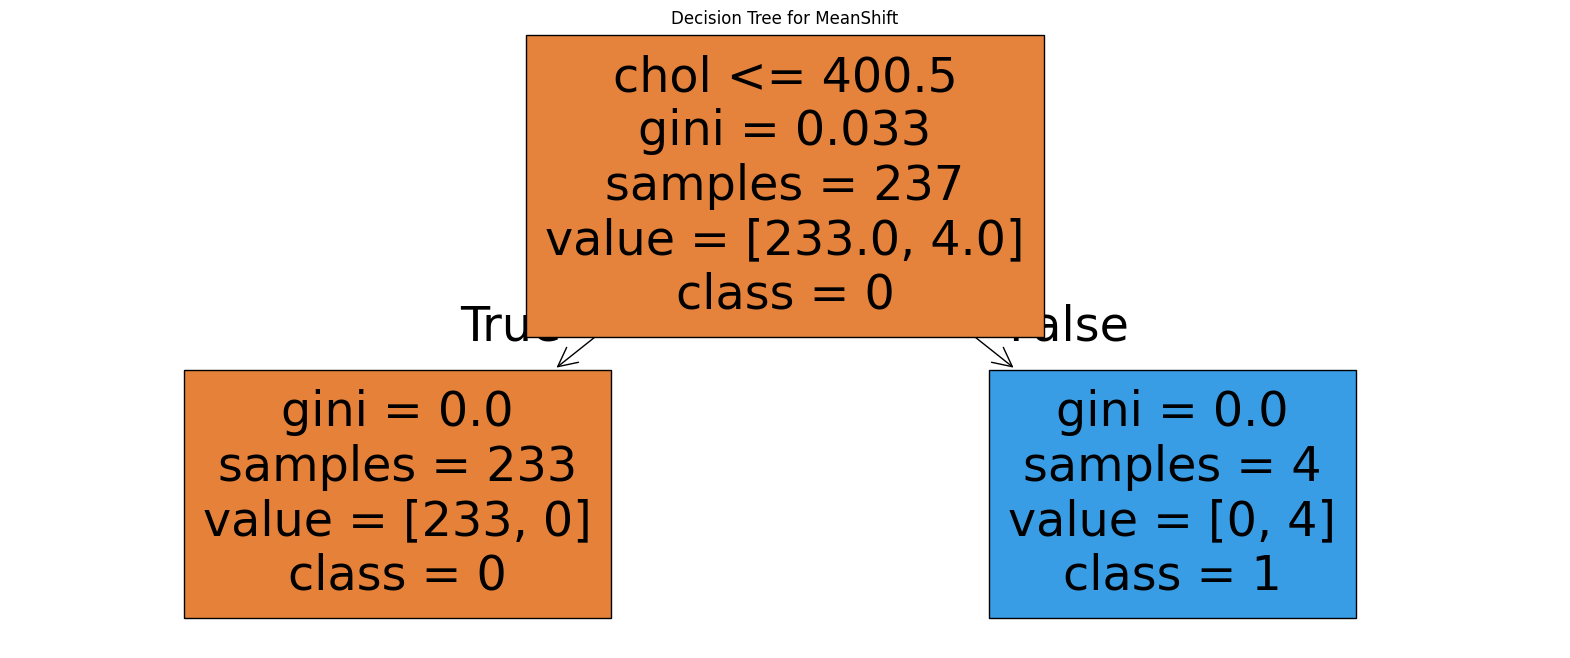

In [40]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=heart_disease.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[0]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [51]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.1)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.361] R5: sex = 1.0
			0: 0.361	1: 0.000	Unc: 0.639

	[0.328] R1: 48.566 < age < 54.612
			0: 0.328	1: 0.000	Unc: 0.672

	[0.326] R35: slope = 3.0
			0: 0.326	1: 0.000	Unc: 0.674

	[0.312] R24: 132.845 < thalach < 148.481
			0: 0.312	1: 0.000	Unc: 0.688

	[0.303] R11: 120.113 < trestbps < 132.253
			0: 0.303	1: 0.000	Unc: 0.697

	[0.302] R18: fbs = 0.0
			0: 0.302	1: 0.000	Unc: 0.698

	[0.291] R34: slope = 2.0
			0: 0.287	1: 0.007	Unc: 0.706

	[0.290] R26: thalach > 164.117
			0: 0.290	1: 0.000	Unc: 0.710

	[0.286] R33: slope = 1.0
			0: 0.286	1: 0.000	Unc: 0.714

	[0.285] R27: exang = 0.0
			0: 0.284	1: 0.002	Unc: 0.714

	[0.285] R20: restecg = 0.0
			0: 0.285	1: 0.000	Unc: 0.715

	[0.268] R7: cp = 2.0
			0: 0.268	1: 0.000	Unc: 0.732

	[0.266] R23: thalach < 132.845
			0: 0.266	1: 0.000	Unc: 0.734

	[0.265] R29: oldpeak < 0.273
			0: 0.265	1: 0.000	Unc: 0.735

	[0.250] R6: cp = 1.0
			0: 0.250	1: 0.000	Unc: 0.750

	[0.250] R31: 1.038 

# Segundo algoritmo

In [42]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[1]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[chol=233.0-244.0^trestbps=135.0-140.0] V [chol=221.6-233.0^exang=0^age=56.0-58.0] V [trestbps=135.0-140.0^chol=221.6-233.0]]

Reglas para clase: 1
[[trestbps=>152.8^ca=3.0] V [thalach=<114.6^age=56.0-58.0]]

Reglas para clase: 2
[[thalach=157.0-162.0^chol=192.6-206.2] V [chol=206.2-221.6^fbs=1]]

Reglas para clase: 3
[[chol=<192.6^ca=0.0^cp=3] V [chol=<192.6^slope=1^cp=4] V [chol=192.6-206.2^restecg=2]]

Reglas para clase: 4
[[chol=>308.4^trestbps=>152.8]]

Reglas para clase: 5
[[thalach=<114.6^trestbps=120.0-126.8]]

Reglas para clase: 6
[[chol=285.6-308.4^slope=1]]

Reglas para clase: 7
[[chol=>308.4^sex=0^trestbps=135.0-140.0]]

Reglas para clase: 8
[[trestbps=>152.8^thal=7.0^age=53.0-56.0] V [cp=1^chol=285.6-308.4]]

Reglas para clase: 9
[[chol=>308.4^oldpeak=1.5-1.9] V [ca=3.0^oldpeak=>2.8]]

Reglas para clase: 10
[]

Reglas para clase: 11
[[chol=244.0-256.6^thalach=>174.0] V [thalach=>174.0^chol=256.6-269.0] V [thalach=169.0-174.0^chol=256.6-

Decision Tree:


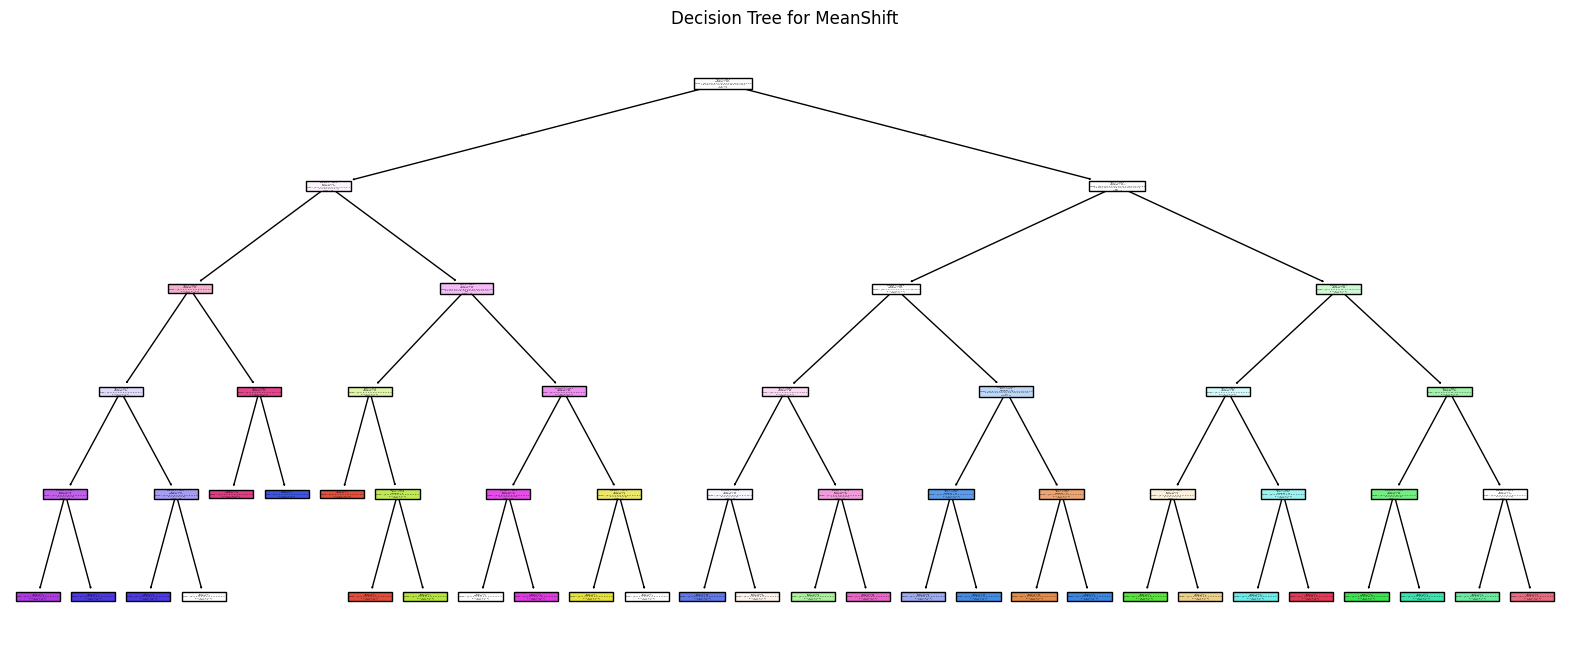

In [43]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=heart_disease.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[1]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [44]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.445] R15: 213.187 < chol < 248.460
			0: 0.205	1: 0.000	2: 0.046	3: 0.000	4: 0.000	5: 0.061	6: 0.000	7: 0.000	8: 0.000	9: 0.000	10: 0.000	11: 0.006	12: 0.218	13: 0.000	14: 0.206	15: 0.000	16: 0.222	17: 0.000	18: 0.000	19: 0.000	20: 0.000	Unc: 0.036

	[0.419] R12: 132.253 < trestbps < 144.393
			0: 0.177	1: 0.000	2: 0.079	3: 0.109	4: 0.025	5: 0.000	6: 0.122	7: 0.165	8: 0.000	9: 0.124	10: 0.000	11: 0.059	12: 0.003	13: 0.066	14: 0.000	15: 0.004	16: 0.016	17: 0.039	18: 0.009	19: 0.000	20: 0.000	Unc: 0.004

	[0.410] R31: 1.038 < oldpeak < 1.803
			0: 0.169	1: 0.009	2: 0.001	3: 0.070	4: 0.000	5: 0.004	6: 0.198	7: 0.084	8: 0.033	9: 0.056	10: 0.000	11: 0.006	12: 0.047	13: 0.053	14: 0.000	15: 0.000	16: 0.160	17: 0.037	18: 0.030	19: 0.042	20: 0.000	Unc: 0.001

	[0.393] R18: fbs = 0.0
			0: 0.162	1: 0.024	2: 0.000	3: 0.066	4: 0.042	5: 0.160	6: 0.083	7: 0.009	8: 0.000	9: 0.000	10: 0.000	11: 0.022	12: 0.076	13: 0.000	14: 0.015	15: 0.033	16: 0.112	

# Tercer algoritmo

In [45]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[2]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[chol=206.2-221.6] V [chol=192.6-206.2] V [chol=<192.6]]

Reglas para clase: 1
[[chol=285.6-308.4] V [chol=>308.4]]

Reglas para clase: 2
[[chol=256.6-269.0] V [chol=244.0-256.6] V [chol=221.6-233.0] V [chol=269.0-285.6] V [chol=233.0-244.0]]


Decision Tree:


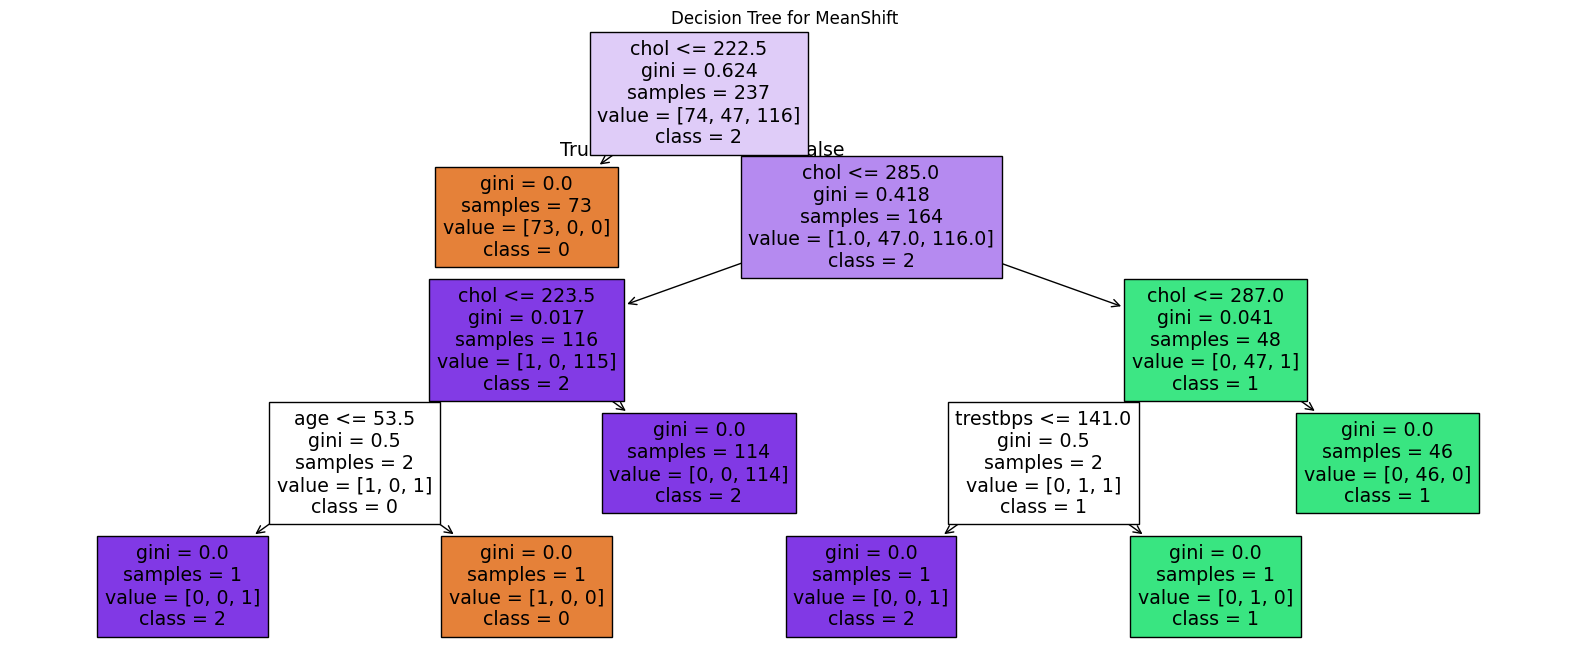

In [46]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=heart_disease.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[2]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [47]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.860] R14: chol < 213.187
			0: 0.860	1: 0.000	2: 0.000	Unc: 0.140

	[0.465] R32: oldpeak > 1.803
			0: 0.447	1: 0.037	2: 0.000	Unc: 0.516

	[0.425] R21: restecg = 1.0
			0: 0.220	1: 0.602	2: 0.000	Unc: 0.178

	[0.375] R23: thalach < 132.845
			0: 0.327	1: 0.000	2: 0.104	Unc: 0.570

	[0.345] R8: cp = 3.0
			0: 0.245	1: 0.050	2: 0.189	Unc: 0.516

	[0.344] R10: trestbps < 120.113
			0: 0.282	1: 0.055	2: 0.083	Unc: 0.580

	[0.335] R41: thal = 6.0
			0: 0.275	1: 0.128	2: 0.005	Unc: 0.592

	[0.328] R37: ca = 1.0
			0: 0.214	1: 0.030	2: 0.259	Unc: 0.498

Most important rules for class 1

	[0.840] R17: chol > 283.733
			0: 0.000	1: 0.840	2: 0.000	Unc: 0.160

	[0.703] R21: restecg = 1.0
			0: 0.220	1: 0.602	2: 0.000	Unc: 0.178

	[0.591] R39: ca = 3.0
			0: 0.001	1: 0.573	2: 0.035	Unc: 0.390

	[0.405] R4: sex = 0.0
			0: 0.033	1: 0.357	2: 0.070	Unc: 0.540

	[0.383] R42: thal = 7.0
			0: 0.007	1: 0.316	2: 0.141	Unc: 0.536

	[0.322] R25: 148.481 